In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
from shapely.geometry import MultiPolygon, Polygon, Point
from sklearn.cluster import KMeans
from geopy.distance import distance
from ast import literal_eval
import math 
from geopy.distance import distance
import pyproj
import ast
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def plot_data(df, title):
    # Separate x and y values from the coordinate tuples and get masses of each point
    x_values = [row['Biomass location'][0] for _, row in df.iterrows()]
    y_values = [row['Biomass location'][1] for _, row in df.iterrows()]
    mass_values = df['Mass'].values

    # Plot the data with the colors based on mass
    fig, ax = plt.subplots(figsize=(8, 8))
    sc = ax.scatter(x_values, y_values, c=mass_values, cmap='viridis', s=100)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.title(' '.join(title.split(' ')[:4]) + '\n' + ' '.join(title.split(' ')[4:]), fontsize=16)
    plt.tick_params(labelsize=12)
    
    # Add a colorbar to show the mass values
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Mass', fontsize=14)
    
    path = './pdfs/'
    fig.savefig(path + title+'.pdf')
    
    plt.show()


In [3]:
def load_and_process_data(filename):
    # Read the CSV file and specify the data types of the columns
    dtypes = {'Area': str}
    df = pd.read_csv(filename, header=0, sep=';', dtype=dtypes)

    # Replace characters in the Area column and split it into separate columns
    replacements = {'(': '', ')': '', 'MULTIPOLYGON': ''}
    for index1, row in df.iterrows():
        input_string = str(df['Area'][index1])
        for old, new in replacements.items():
            input_string = input_string.replace(old, new)
        coordinates = input_string.split(',')
        for index2, coordinate in enumerate(coordinates):
            df.loc[index1,'Coordinate '+ str(index2)]=coordinate

    # Calculate the mean points of biomass potentials and replace the coordinates with them
    df2 = df[['Coordinate 0','Coordinate 1','Coordinate 2','Coordinate 3']]
    df2 = df2.apply(lambda row: tuple(map(lambda x: np.sum(x)/len(x), zip(*[map(float, str(c).split()) for c in row]))), axis=1)
    df['Biomass location'] = df2

    # Clean the dataframe
    df = df.loc[:, ['Mass','Biomass location']]
    mask = df['Biomass location'].apply(is_2d_tuple)
    df = df[mask]
    
    return df


In [4]:
def clean_data(df,radius,facilityloc):

    # Clean the data (df) from the rows that are further away than the assumed maximum distance (radius)
    # from the biogas facility locations (facilityloc). 

    # Check input parameters
    if not isinstance(facilityloc, tuple) or len(facilityloc) != 2 or \
       not all(isinstance(x, (int, float)) for x in facilityloc):
        raise ValueError('facilityloc must be a tuple with two numeric elements')

    # Define the WGS84 and EUREF-FIN coordinate systems
    wgs84 = pyproj.CRS('EPSG:4326')
    euref_fin = pyproj.CRS('EPSG:3067')
    
    # Transform the facility location to EUREF-FIN coordinates
    transformer = pyproj.Transformer.from_crs(wgs84, euref_fin, always_xy=True)
    facility_euref_x, facility_euref_y = transformer.transform(facilityloc[1], facilityloc[0])
    facility_loc = (facility_euref_x, facility_euref_y)
 
    
    # Calculate the distances
    distances = df['Biomass location'].apply(lambda loc: math.sqrt(pow(facility_loc[0]-loc[0],2)+pow(facility_loc[1]-loc[1],2))/1000)

    # Filter the data
    df = df.loc[distances <= radius].reset_index(drop=True)
    
    # Remove zero masses from data
    df = df.loc[(df != 0).all(axis=1)]

    return df

In [5]:
def is_2d_tuple(val):
    
    # Check whether val given as parameter is in expected form of tuple. is used by load_and_process data.
    
    return isinstance(val, tuple) and len(val) == 2 and all(isinstance(x, (int, float)) for x in val)

In [6]:
filename = input("Enter biomassdata filename: ") + '.csv'
path = './datasets/'
df = load_and_process_data(path+filename)
file = filename.split('.',1)[0]
df

Enter biomassdata filename: Siipikarjankuivalantavarastosta2016


C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_25040\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

,Mass,Biomass location
0,1.161320,"(273500.0, 6661500.0)"
1,1.058603,"(226500.0, 7026500.0)"
2,6.842893,"(277500.0, 6758500.0)"
3,2.887587,"(308500.0, 7026500.0)"
4,6.842893,"(296500.0, 6760500.0)"
...,...,...
54639,11.424005,"(297500.0, 6948500.0)"
54640,3.231107,"(364500.0, 6807500.0)"
54641,10.950146,"(285500.0, 6958500.0)"
54642,7.754065,"(261500.0, 6949500.0)"


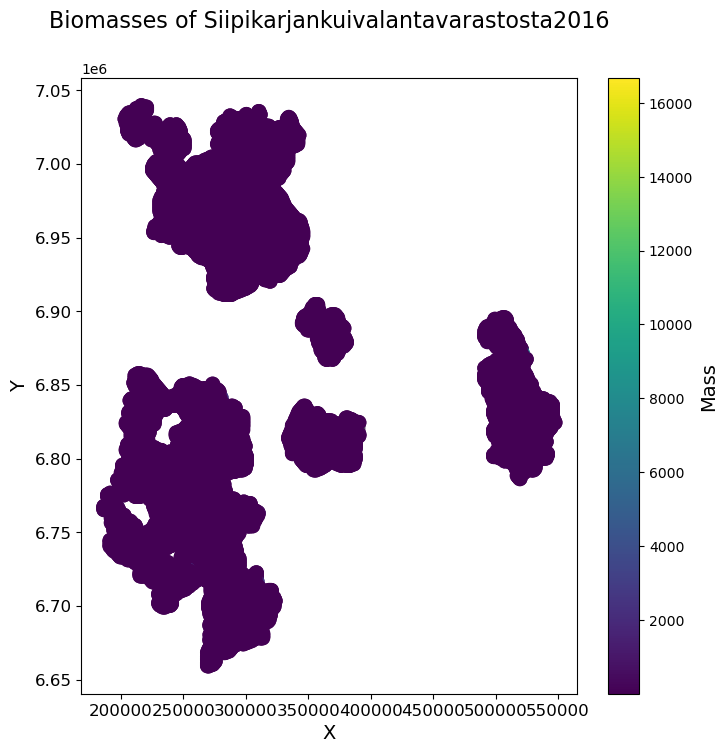

In [7]:
plot_data(df,'Biomasses of ' + file)

In [8]:
#facilityLocation = ast.literal_eval(input("Enter the location of the biogas facility in lon-lat coordinates in the form of (lon, lat): "))
#greatestDistance = int(input("Enter greatest distance (km) within the radius of which the biomasses are included: "))

# Coordinates for Envor's facility: (60.929833, 23.369694)

#df = clean_data(df,greatestDistance,facilityLocation)
df = clean_data(df,50,(60.929833, 23.369694))

df

,Mass,Biomass location
0,6.842893,"(277500.0, 6758500.0)"
1,6.842893,"(296500.0, 6760500.0)"
2,6.842893,"(272500.0, 6761500.0)"
3,6.842893,"(274500.0, 6761500.0)"
4,22.847485,"(273500.0, 6791500.0)"
...,...,...
6349,10.419708,"(269500.0, 6744500.0)"
6350,1.695207,"(293500.0, 6802500.0)"
6351,6.842893,"(290500.0, 6744500.0)"
6352,1.695207,"(294500.0, 6805500.0)"


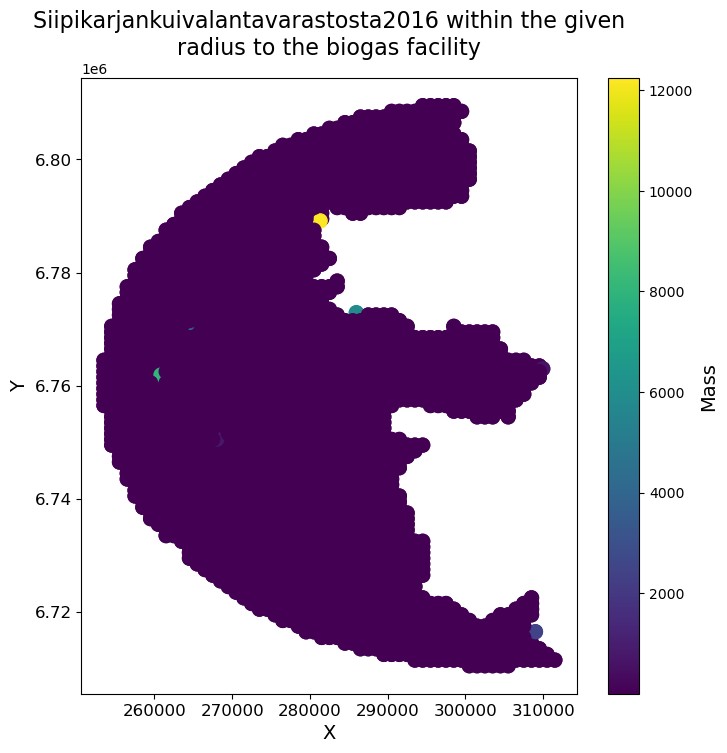

In [9]:
plot_data(df,file+' within the given radius to the biogas facility')

In [ ]:
# Tsekkaa paperi GIS-data related route optimization, hierarchical clustering, location
# optimization, and kernel density methods are useful for promoting
# distributed bioenergy plant planning in rural areas
# K. Laasasenahoa*, A. Lensub*, R. Lauhanenc
# and J. Rintalaa

# Clustering the data with K-means. Utilzing the elbow method to decide optimal value for k.
# The basic idea in elbow method is to plot the within-cluster 
# sum of squares (WCSS) against the number of clusters, and choose the number of clusters 
# at the "elbow" point where the rate of decrease in WCSS slows down significantly.

# To be used in consideration of mass distribution. Each coordinate will be multiplied 
# with their MassCoefficient in clustering
# to give more weight to the points with greater mass. 

df['MassCoefficient'] = df['Mass'].apply(round).astype(int).clip(lower=1)
df['LocationWithMassCoefficient'] = df['Biomass location'] * df['MassCoefficient']

coords = df['LocationWithMassCoefficient'].explode().tolist()
LocationMassCoords = [(coords[i], coords[i+1]) for i in range(0, len(coords)-1, 2)]
LocationMassCoords = np.array(LocationMassCoords)

k_vals = list(range(1,100))
wcss = []
labels=[]

for i in k_vals:    
    kmeans = KMeans(n_clusters=i,n_init='auto')
    kmeans.fit(LocationMassCoords)
    wcss.append(kmeans.inertia_)
    labels.append(kmeans.predict(LocationMassCoords))


In [ ]:
# Plot the WCSS values against the number of clusters
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Based on the graph above, close to optimal and good enough k-values for this datasets is 60.
# Let's plot the data with 60 clusters.
# Plotting the data

KCLUSTERS = 60

plt.scatter(LocationMassCoords[:,0],LocationMassCoords[:,1],c=labels[KCLUSTERS-1])

In [ ]:
kmeans = KMeans(n_clusters=KCLUSTERS,n_init='auto')
kmeans.fit(LocationMassCoords)

locations = df['Biomass location'].tolist()
locations = np.array(locations)

df['Cluster'] = kmeans.predict(locations)
df

In [ ]:
# Getting masses and locations for each cluster

cluster_masses = [[] for _ in range(KCLUSTERS)]
cluster_locations = [[] for _ in range(KCLUSTERS)]

for index, row in df.iterrows():
    cluster_masses[row['Cluster']].append(row['Mass'])
    cluster_locations[row['Cluster']].append(row['Biomass location'])

In [ ]:
# Calculate the weighted average centroid for clusters:

weighted_avg_centroids = []
sum_cluster_masses = []

for i in range(KCLUSTERS):
    sum_x = np.sum([mass * loc[0] for mass, loc in zip(cluster_masses[i], cluster_locations[i])])
    sum_y = np.sum([mass * loc[1] for mass, loc in zip(cluster_masses[i], cluster_locations[i])])
    weighted_avg_centroids.append((sum_x / np.sum(cluster_masses[i]), sum_y / np.sum(cluster_masses[i])))
    sum_cluster_masses.append(np.sum(cluster_masses[i]))


In [ ]:
# Set up a colormap to color the centroids based on their sum of masses
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(np.array(sum_cluster_masses).min(), np.array(sum_cluster_masses).max())

# Plotting the data with the centroids
fig, ax = plt.subplots(figsize=(10,10))

# scatter plot of data points and their clusters
plt.scatter(locations[:, 0], locations[:, 1], c=df['Cluster'])


# scatter plot of cluster centroids colored by their sum of masses
centroids = np.array(weighted_avg_centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='.', s=200, linewidths=3, c=sum_cluster_masses, cmap=cmap, norm=norm)

# Add a colorbar to show the colormap legend
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sum of Masses')

plt.title('Pickup sites for the file '+' '.join(filename.split(' ')[:4]) + '\n' + ' '.join(filename.split(' ')[4:]), fontsize=16)

path = './pdfs/'
fig.savefig(path + 'Pickup sites for the file '+filename+'.pdf')

plt.show()

In [ ]:
# Clusters to df

df = pd.DataFrame({'ClusterLocations': weighted_avg_centroids, 'Clustermasses': sum_cluster_masses}, index=range(1, len(weighted_avg_centroids)+1))


In [ ]:
# define the ETRS-TM35FIN projection
etrs_tm35fin = pyproj.Proj("+proj=utm +zone=35 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

# define a function to convert EUREF-FIN coordinates to lon-lat
def euref_fin_to_lon_lat(row):
    lon, lat = etrs_tm35fin(row['ClusterLocations'][0], row['ClusterLocations'][1], inverse=True)
    return pd.Series({'lon': lon, 'lat': lat})

In [ ]:
df[['lon','lat']] = df.apply(euref_fin_to_lon_lat,axis=1)

In [ ]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.drop('ClusterLocations',axis=1) # Not needed anymore, these are in the wrong form of coordinates

## save the GeoDataFrame to a GeoJSON file
path = './geojsons/'
gdf.to_file(path + file+'.geojson', driver='GeoJSON')